<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações 

In [4]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [5]:
!rm -rf geological_similarity

# **Coleta de dados do Kaglle**

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabiobasson","key":"d71cbfdfd23379909173204eac74cf96"}'}

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


# **###  Download dos dados / descompactando os dados**

In [9]:
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq  geological-image-similarity

 51% 17.0M/33.6M [00:00<00:00, 53.0MB/s]
100% 33.6M/33.6M [00:00<00:00, 84.9MB/s]


In [ ]:
#!kaggle datasets download fabiobasson/geological-similarity
#! unzip -qq  geological-similarity

geological-similarity.zip: Skipping, found more recently modified local copy (use --force to force download)


# ** Criação da estrutura e Dataframe**

In [10]:
andesite_dir = glob.glob('geological_similarity/andesite/*.jpg');gneiss_dir = glob.glob('geological_similarity/gneiss/*.jpg')
marble_dir = glob.glob('geological_similarity/marble/*.jpg');quartzite_dir = glob.glob('geological_similarity/quartzite/*.jpg')
rhyolite_dir = glob.glob('geological_similarity/rhyolite/*.jpg');
schist_dir = glob.glob('geological_similarity/schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))


5000
5000
4998
5000
5000
5000


In [11]:
andesite_dir[0:4]

['geological_similarity/andesite/9AA5X.jpg',
 'geological_similarity/andesite/FQGXN.jpg',
 'geological_similarity/andesite/5BW0Y.jpg',
 'geological_similarity/andesite/HZE4C.jpg']

In [12]:
class_names = ['andesite', 'gneiss', 'marbler', 'quartzite', 'rhyolite','schist']
class_names[0]

'andesite'

In [13]:
andesite_df=[];gneiss_df=[];marble_df=[]
quartzite_df=[]
rhyolite_df=[]
schist_df=[]

for i in andesite_dir:
    andesite_df.append([i,class_names[0]])
for j in gneiss_dir:
   gneiss_df.append([j,class_names[1]])
for l in marble_dir:
    marble_df.append([l,class_names[2]])
for m in quartzite_dir:
    quartzite_df.append([m,class_names[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,class_names[4]])
for o in schist_dir:
    schist_df.append([o,class_names[5]])
   
df = andesite_df + gneiss_df + marble_df + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
df

[['geological_similarity/quartzite/6S1ZB.jpg', 'quartzite'],
 ['geological_similarity/andesite/6Y4AQ.jpg', 'andesite'],
 ['geological_similarity/rhyolite/FLGWL.jpg', 'rhyolite'],
 ['geological_similarity/rhyolite/VY06V.jpg', 'rhyolite'],
 ['geological_similarity/schist/GBWT0.jpg', 'schist'],
 ['geological_similarity/quartzite/PXLJW.jpg', 'quartzite'],
 ['geological_similarity/gneiss/VBBH1.jpg', 'gneiss'],
 ['geological_similarity/schist/JZ5Q4.jpg', 'schist'],
 ['geological_similarity/quartzite/MJMUR.jpg', 'quartzite'],
 ['geological_similarity/gneiss/DULCW.jpg', 'gneiss'],
 ['geological_similarity/andesite/FGUMP.jpg', 'andesite'],
 ['geological_similarity/andesite/3PFI1.jpg', 'andesite'],
 ['geological_similarity/andesite/UGRBE.jpg', 'andesite'],
 ['geological_similarity/andesite/7U4MN.jpg', 'andesite'],
 ['geological_similarity/marble/HC3AQ.jpg', 'marbler'],
 ['geological_similarity/marble/NS1U7.jpg', 'marbler'],
 ['geological_similarity/marble/UX9TV.jpg', 'marbler'],
 ['geological_si

In [14]:
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,geological_similarity/quartzite/6S1ZB.jpg,quartzite
1,geological_similarity/andesite/6Y4AQ.jpg,andesite
2,geological_similarity/rhyolite/FLGWL.jpg,rhyolite
3,geological_similarity/rhyolite/VY06V.jpg,rhyolite
4,geological_similarity/schist/GBWT0.jpg,schist
...,...,...
29993,geological_similarity/quartzite/NI7LB.jpg,quartzite
29994,geological_similarity/quartzite/NHGE8.jpg,quartzite
29995,geological_similarity/andesite/G6SE8.jpg,andesite
29996,geological_similarity/quartzite/38GGV.jpg,quartzite


In [15]:
data_df.dtypes

path     object
label    object
dtype: object

# **Limpeza de dados**
1 - Analisando os dados ausentes
2 - Descartando os dados ausentes
3 - Imputando dados
4 - Acrescentando colunas informativas

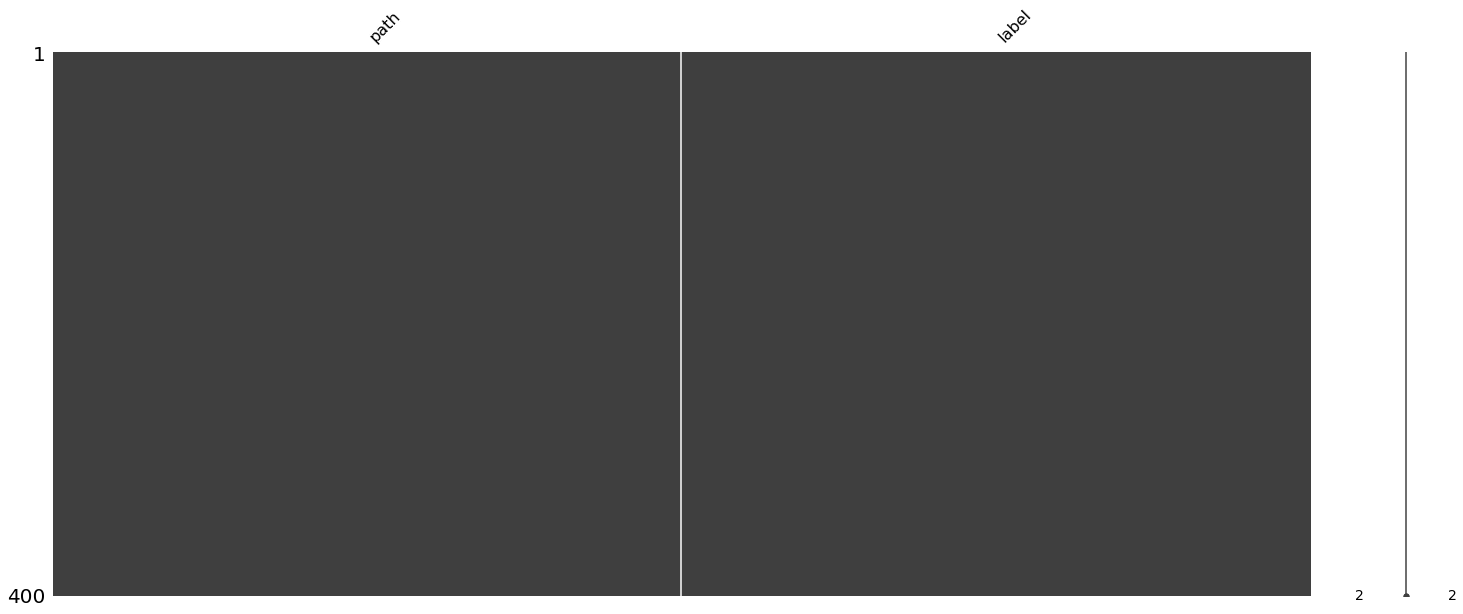

In [16]:
import missingno as msno
ax = msno.matrix(data_df.sample(400))

In [18]:
#! pip install pandas-profiling==2.8.0
#from pandas_profiling import ProfileReport
#ProfileReport (data_df)

# **Separação das amostras**

In [17]:
X = data_df.drop(columns='label')
y = data_df.path

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=44)

# **Explorando os dados**

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23998, 1)
(6000, 1)
(23998,)
(6000,)


In [ ]:
#fig, ax = plt.subplots(figsize=(6,4))
#X.plot(kind="hist",ax=ax)

# **Data Argumentation**

## ** Esta função irá plotar as imagens num grid de 1 a 5 colunas **

In [28]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [29]:
IMG_SHAPE = 28
BATCH_SIZE = 20

In [30]:
datagen = ImageDataGenerator(rescale=1./255,
                            #rotation_range = 40,
                            #width_shift_range = 0.2,
                            #height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split=0.2)

In [31]:
train_generator = datagen.flow_from_dataframe(data_df,
                                              x_col='path',
                                              y_col='label',
                                              images_size=(28,28),
                                              #class_mode='binary',
                                              subset='training')

validation_generator = datagen.flow_from_dataframe(data_df,
                                                   x_col='path',
                                                   y_col='label',
                                                   images_size=(28,28),
                                                   #class_mode='binary',
                                                   subset='validation')

## Duvidas - Existe esse codigo abaixo

#test_generator = datagen.flow_from_dataframe(data_df,
                                              #x_col='path',
                                             # y_col='label',
                                             # images_size=(28,28)
                                              #class_mode='binary')
                                             # )

Found 23999 validated image filenames belonging to 6 classes.
Found 5999 validated image filenames belonging to 6 classes.


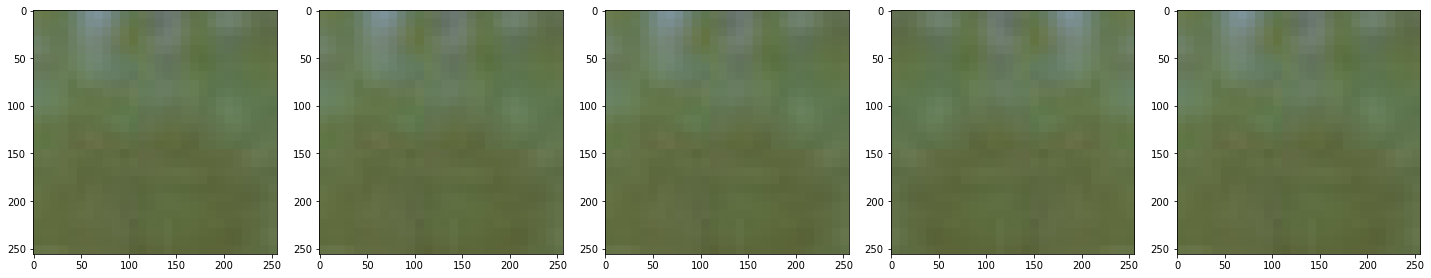

In [32]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Imputação dos dados ???**

# **Normalização dos dados ???**

# **Pre Processamento dos dados**

# **Criar o modelo**

In [73]:
inputs = tf.keras.Input(shape=(256, 256,3))
x = augmented_images(inputs) # como conserto e passo isso
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


TypeError: ignored

In [92]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    #tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6)
])

# **Compilando o Modelo**

In [93]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['accuracy'])

In [94]:
model.summary()  

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 254, 254, 256)     7168      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 127, 127, 256)     0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 125, 125, 64)      147520    
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 30, 128)      

In [95]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        #restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        save_best_only=True,
    ),

]

# **Avaliar o modelo**

In [ ]:
history = model.fit(train_generator,
                               epochs=20,
                               #verbose=0,
                               callbacks=callbacks_list, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               #workers=4,
                               #use_multiprocessing=True,
                               validation_data=validation_generator)

Epoch 1/20


# **Otimizar o modelo**